In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Load and preprocess dataset
file_path = 'malicious_phish.csv'  # Replace with actual dataset
data = pd.read_csv(file_path)


In [ ]:
# Encode 'type' column
label_encoder = LabelEncoder()
data['type_encoded'] = label_encoder.fit_transform(data['type'])

In [ ]:
# TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=500)
url_features = vectorizer.fit_transform(data['url'])


In [ ]:
# Prepare dataset
processed_data = pd.DataFrame.sparse.from_spmatrix(url_features)
processed_data['type'] = data['type_encoded'].values


In [ ]:
X_train = processed_data.drop(columns=['type']).to_numpy()
y_train = processed_data['type'].to_numpy()

# Normalize input features
X_min, X_max = np.min(X_train), np.max(X_train)
X_train = (X_train - X_min) / (X_max - X_min)

In [ ]:
# Define GAN architecture
latent_dim = 64

def build_generator(latent_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation="relu", input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation="tanh")
    ])
    return model

def build_discriminator(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, activation="relu", input_dim=input_dim),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

generator = build_generator(latent_dim, X_train.shape[1])
discriminator = build_discriminator(X_train.shape[1])

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy", metrics=["accuracy"])
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)
gan = tf.keras.Model(gan_input, gan_output)

gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss="binary_crossentropy")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 [D loss: 0.6931, acc: 32.03] [G loss: 0.8050]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 10 [D loss: 0.6836, acc: 44.54] [G loss: 0.7585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Epoch 20 [D loss: 0.6926, acc: 39.42] [G loss: 0.7060]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


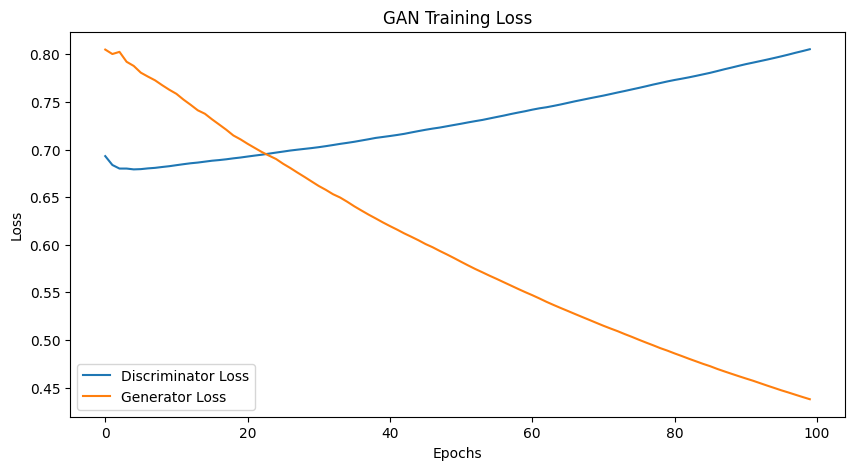

In [ ]:
# Training GAN
def train_gan(generator, discriminator, gan, data, epochs=100, batch_size=64):
    half_batch = batch_size // 2
    d_losses, g_losses = [], []

    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        real_labels = np.ones((half_batch, 1))

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

    plt.figure(figsize=(10,5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Loss')
    plt.show()

train_gan(generator, discriminator, gan, X_train, epochs=100, batch_size=64)


In [ ]:
# Generate synthetic data
num_samples = 5000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_features = generator.predict(noise)
synthetic_features = (synthetic_features * (X_max - X_min)) + X_min

# Merge some real data for realism
real_sampled = data.sample(n=1000, random_state=42)
real_sampled = real_sampled[['url', 'type']]

# Generate synthetic URLs
import random

def generate_fake_url():
    prefixes = ["http://", "https://", "www."]
    domains = ["securecheck", "malwarescan", "testsite", "clickverify", "safebrowsing"]
    extensions = [".com", ".net", ".org", ".info", ".xyz"]
    return random.choice(prefixes) + random.choice(domains) + random.choice(extensions)

synthetic_urls = [generate_fake_url() for _ in range(num_samples)]
synthetic_labels = np.random.choice(data['type'], size=num_samples, replace=True)

synthetic_df = pd.DataFrame({"url": synthetic_urls, "type": synthetic_labels})
synthetic_df = pd.concat([synthetic_df, real_sampled], ignore_index=True)

synthetic_df.to_csv("enhanced_synthetic_dataset.csv", index=False)
print("Enhanced synthetic dataset saved.")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Enhanced synthetic dataset saved.


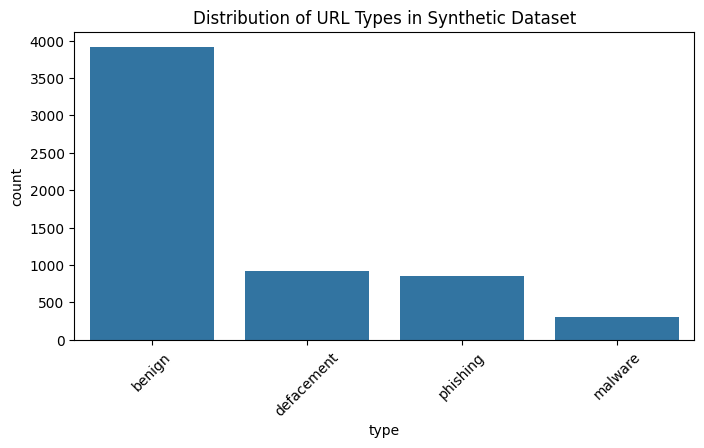

In [ ]:
# Data visualization
plt.figure(figsize=(8, 4))
sns.countplot(data=synthetic_df, x="type", order=synthetic_df['type'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of URL Types in Synthetic Dataset")
plt.show()

